<a href="https://colab.research.google.com/github/andandaks/oilreports/blob/main/Oil_analyze_with_automl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import os, sys
from pandas.plotting import scatter_matrix
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import r2_score
from scipy.stats import variation
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.utils.validation import check_array
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import lightautoml
from lightautoml.tasks import Task
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from sklearn.model_selection import train_test_split
from itertools import compress, product
from sklearn.metrics import roc_auc_score

# from pmdarima import auto_arima

In [ ]:
# Open a file
path = "/Users/andaks/Documents/oil_gas_train_test"
dirs = os.listdir(path)

In [ ]:
#read excel files, convert them to pandas data frames

# make an empty data frame
d = {'Name': [0], 'Date': [0], 'Revenue': [0], 'Operating Income': [0] }
df = pd.DataFrame(data = d)

# read all the files with data and join them together
for file in dirs:
#use cringe name lol
    lol = pd.read_excel("/Users/andaks/Documents/oil_gas_train_test/" + str(file))
# delete empty columns and rows
    lol = lol.drop(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
           'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'], axis = 1)
    lol = lol.drop(lol.index[:26])
    lol = lol.loc[[26, 28, 42, 165, 309]]
    
# rename rows
    lol.index = ["Date", "Revenue", 'Operating Income', 'Total Assets', 'Free Cash Flow']
    lol = lol.T

# add stock name
    lol['Name'] = str(file).split('.')[0]

# add its own color (for further work)
    import random
    col = ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])]
    lol['Color'] = col[0]
    
# add stock data to the main data set
    df = pd.concat([df, lol])

# remove empty first line
df = df.iloc[1: , :]
df = df.reset_index(drop = True)

df

,Name,Date,Revenue,Operating Income,Total Assets,Free Cash Flow,Color
0,CDEV,Q1 '11 A,0,0,0,0,#2E82E7
1,CDEV,Q2 '11 A,0,0,0,0,#2E82E7
2,CDEV,Q3 '11 A,0,0,0,0,#2E82E7
3,CDEV,Q4 '11 A,0,0,0,0,#2E82E7
4,CDEV,Q1 '12 A,0,0,0,0,#2E82E7
...,...,...,...,...,...,...,...
2179,MCF,Q2 '20 A,17.842,-21.275,195.531008,-1.843,#C289E9
2180,MCF,Q3 '20 A,31.348,2.521,192.819008,15.766,#C289E9
2181,MCF,Q4 '20 A,29.157,-0.874,170.267008,0,#C289E9
2182,MCF,Q1 '21 A,59.95,13.62,436.308992,-88.678,#C289E9


In [ ]:
df[20:]

,Name,Date,Revenue,Operating Income,Total Assets,Free Cash Flow,Color
20,CDEV,Q1 '16 A,23.75,-6.105,501.80432,-3.867,#2E82E7
21,CDEV,Q2 '16 A,29.39,0.056,501.273984,6.394,#2E82E7
22,CDEV,Q3 '16 A,29.273,-1.775,501.04992,3.575,#2E82E7
23,CDEV,Q4 '16 A,30.771,-1.932,2651.642112,-865.139968,#2E82E7
24,CDEV,Q1 '17 A,60.7,7.653,2653.755904,-82.69,#2E82E7
...,...,...,...,...,...,...,...
2179,MCF,Q2 '20 A,17.842,-21.275,195.531008,-1.843,#C289E9
2180,MCF,Q3 '20 A,31.348,2.521,192.819008,15.766,#C289E9
2181,MCF,Q4 '20 A,29.157,-0.874,170.267008,0,#C289E9
2182,MCF,Q1 '21 A,59.95,13.62,436.308992,-88.678,#C289E9


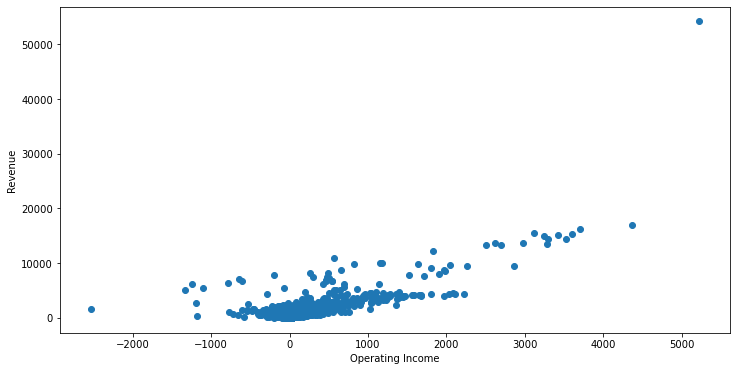

In [ ]:
import matplotlib.pyplot as plt 

# Let's vizualise this data
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(df['Operating Income'], df['Revenue']) 
ax.set_xlabel('Operating Income')
ax.set_ylabel('Revenue')
plt.show() 

## We have a visible trend (the higher oper income, the higher revenue and vice versa)

 There are two outliers in our data - they are based in the left down and right up positions. We should drop them to have a better picture.
 
 Two good metrics here are roc_auc and log_loss. Log_loss metric is usefull with financial data as it helps to find differences in percents.
 
 We should try to imply data seasonality and make different plots for different time periods. We have to check this hypothesis.

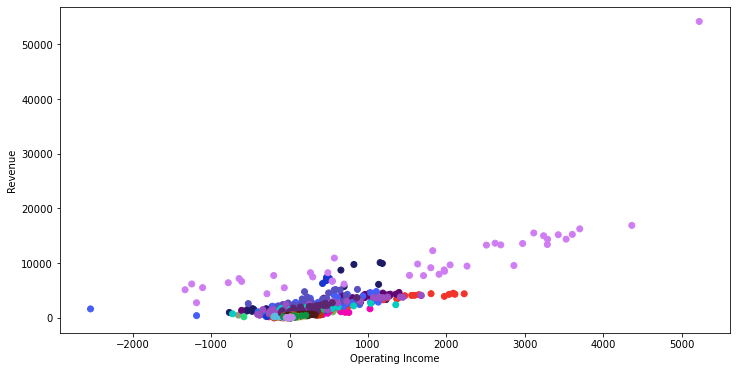

In [ ]:
import matplotlib.pyplot as plt 

# Let's vizualise this data with own colors (different stocks have different colors)
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(df['Operating Income'], df['Revenue'], color = df['Color']) 
ax.set_xlabel('Operating Income')
ax.set_ylabel('Revenue')
plt.show() 

## Baseline solution

In [ ]:
#df2 = df.copy()

In [ ]:
df['Date'] = df['Date'].map(lambda x: x.rstrip('aA'))
df['Date'] = df['Date'].str.replace("'", '20')
df['Date'] = df['Date'].str.replace(r'(Q\d) (\d+)', r'\2-\1')
df['Date'] = pd.to_datetime([
    '-'.join(x.split()[::-1]) for x in df['Date']])
df

/var/folders/gh/dfjmmnfn63s_k8hfzrv1t9m40000gn/T/ipykernel_45667/3940485827.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Date'] = df['Date'].str.replace(r'(Q\d) (\d+)', r'\2-\1')


,Name,Date,Revenue,Operating Income,Total Assets,Free Cash Flow,Color
0,CDEV,2011-01-01,0,0,0,0,#2E82E7
1,CDEV,2011-04-01,0,0,0,0,#2E82E7
2,CDEV,2011-07-01,0,0,0,0,#2E82E7
3,CDEV,2011-10-01,0,0,0,0,#2E82E7
4,CDEV,2012-01-01,0,0,0,0,#2E82E7
...,...,...,...,...,...,...,...
2179,MCF,2020-04-01,17.842,-21.275,195.531008,-1.843,#C289E9
2180,MCF,2020-07-01,31.348,2.521,192.819008,15.766,#C289E9
2181,MCF,2020-10-01,29.157,-0.874,170.267008,0,#C289E9
2182,MCF,2021-01-01,59.95,13.62,436.308992,-88.678,#C289E9


At this moment I transfered to colab, so, I put previously prepared data frame on GitHub

In [8]:
url = 'https://raw.githubusercontent.com/andandaks/oilreports/main/oil_gas.csv'
df = pd.read_csv(url)

In [9]:
df = df.loc[:, (df.columns != 'Name') & (df.columns != 'Color') & (df.columns != 'Date')]

In [10]:
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style = "darkgrid")

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'Revenue'], df['Revenue'], test_size=0.3, random_state=12, shuffle=True)

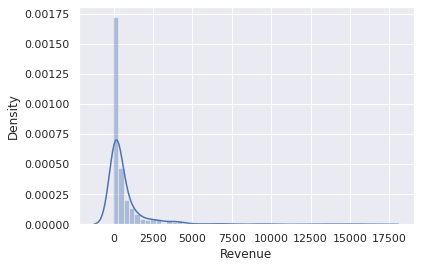

In [11]:
sns.distplot(y_train)
plt.show()

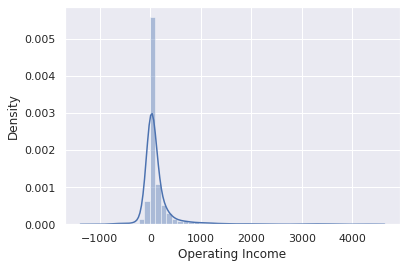

In [12]:
sns.distplot(X_train['Operating Income'])
plt.show()

In [13]:
model = LinearRegression()
model = model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

print(f"Train RMSE = {mse(y_train, y_train_pred, squared=False):.2f}")
print(f"Test RMSE = {mse(y_test, y_pred, squared=False):.2f}")

Train RMSE = 534.91
Test RMSE = 1519.18


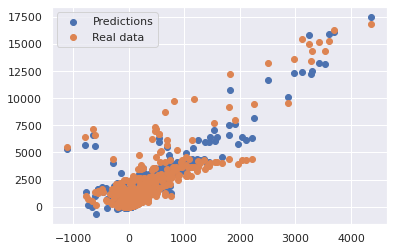

R_2: 0.9043160414683517


In [14]:
plt.scatter(X_train['Operating Income'], y_train_pred, label="Predictions")
plt.scatter(X_train['Operating Income'], y_train, label="Real data")
plt.legend()
plt.show()
print('R_2:', r2_score( y_train, y_train_pred))

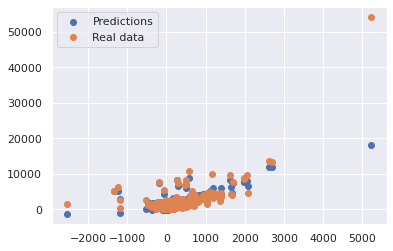

R_2: 0.6683809742100224


In [15]:
plt.scatter(X_test['Operating Income'], y_pred, label="Predictions")
plt.scatter(X_test['Operating Income'], y_test, label="Real data")
plt.legend()
plt.show()
print('R_2:', r2_score( y_test, y_pred))

## SARIMA

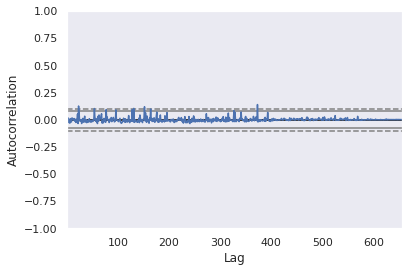

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# check for autocorrelation
pd.plotting.autocorrelation_plot(y_test)

In [ ]:
# Let's find the best parametres
model = auto_arima(y_train, seasonal = True, m=4, trace = True, error_action='ignore', stepwise = True)
model

In [ ]:
model_fit = model.predict(4, y_test)

## LightAutoML

Based on https://github.com/sberbank-ai-lab/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb

In [ ]:
#!pip install git+https://github.com/sberbank-ai-lab/LightAutoML.git

In [31]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 123
TEST_SIZE = 0.3
TIMEOUT = 300
TARGET_NAME = 'Revenue'

data = df

tr_data, te_data = train_test_split(
    data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)
task = Task('reg')
roles = {
    'target': TARGET_NAME
}
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)
te_pred = automl.predict(te_data)

[19:45:44] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[19:45:44] Task: reg



INFO:lightautoml.automl.presets.base:Task: reg



[19:45:44] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[19:45:44] - time: 300.00 seconds


INFO:lightautoml.automl.presets.base:- time: 300.00 seconds


[19:45:44] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[19:45:44] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[19:45:44] Train data shape: (1528, 4)



INFO:lightautoml.reader.base:Train data shape: (1528, 4)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[19:45:52] Layer 1 train process start. Time left 292.55 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 292.55 secs


[19:45:52] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [3], 'embed_sizes': array([11], dtype=int32), 'data_size': 4}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -1975493.5166727009
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -1121930.248239171
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -696185.6694584724
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -285168.40206616925
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = -280961.574241

[19:45:54] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -1233357.979324089


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -1233357.979324089


[19:45:54] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[19:45:54] Time left 290.48 secs



INFO:lightautoml.automl.base:Time left 290.48 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 505462
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l2: 291483
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's l2: 314571
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's l2: 339249
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[207]	valid's l2: 288277


[19:45:54] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[19:45:54] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 505462
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l2: 291483
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's l2: 314571
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's l2: 339249
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best

[19:45:58] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1576611.5249022357


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1576611.5249022357


[19:45:58] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[19:45:58] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 30.50 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 30.50 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-dd6a0ac5-3327-408a-b1d5-519d776f1f8c
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 587756
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l2: 367176
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's l2: 375221
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's l2: 404311
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[246]	valid's l2: 363332
INFO:optuna.study.study:Trial 0 finished with value: -363331.707997626 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.53484076

[19:46:29] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.8792822293371882, 'num_leaves': 104, 'bagging_fraction': 0.763862234170395, 'min_sum_hessian_in_leaf': 0.006900180072555874, 'reg_alpha': 0.003533245669153965, 'reg_lambda': 9.968576440031034}
 achieve -237934.1227 mse


[19:46:29] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 104, 'feature_fraction': 0.8792822293371882, 'bagging_fraction': 0.763862234170395, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.003533245669153965, 'reg_lambda': 9.968576440031034, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'min_sum_hessian_in_leaf': 0.006900180072555874}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 247241
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[80]	valid's l2: 232812
INFO2:lightautoml.ml_al

[19:46:30] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -1675469.9938519616


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -1675469.9938519616


[19:46:30] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[19:46:30] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 2000, 'learning_rate': 0.05, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 300, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 2254.2393522	test: 1468.9624484	best: 1468.9624484 (0)	total: 771us	remaining: 1.54s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 1110.5056025	test: 940.7469306	best: 734.1947102 (26)	total: 60.4ms	remaining: 1.14s
DEBUG:lightautoml.ml_algo.bo

[19:46:32] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -1976507.3789346723


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -1976507.3789346723


[19:46:32] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[19:46:32] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 187.70 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 187.70 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-f3784bc7-8583-4c03-8824-86c46a5afc56
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 2271.3324400	test: 1481.1184304	best: 1481.1184304 (0)	total: 394us	remaining: 788ms
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 1143.7383762	test: 797.5555923	best: 635.9510617 (45)	total: 29.4ms	remaining: 554ms
DEBUG:lightautoml.ml_algo.boost_cb:200:	learn: 1109.6879140	test: 943.5490863	best: 635.9510617 (45)	total: 64.1ms	remaining: 574ms
DEBUG:lightautoml.ml_algo.boost_cb:300:	learn: 1095.8796072	test: 966.4070298	best: 635.9510617 (45)	total: 96.4ms	remaining: 544ms
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (300 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 635.9510617
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 45
INFO3:light

[19:46:55] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 3, 'l2_leaf_reg': 9.896886442422636, 'min_data_in_leaf': 15}
 achieve -342114.6960 mse


[19:46:55] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 9.896886442422636, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'min_data_in_leaf': 15, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 2302.2802759	test: 1508.8293568	best: 1508.8293568 (0)	total: 371us	remaining: 1.11s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 1355.8363124	test: 595.1136729	best: 595.1136729 (100)	total: 28.9ms	remaining: 829ms
D

[19:46:56] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -1937048.3549739923


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -1937048.3549739923


[19:46:56] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[19:46:56] Time left 228.13 secs



INFO:lightautoml.automl.base:Time left 228.13 secs



[19:46:56] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[19:46:56] Blending: optimization starts with equal weights and score -1582257.2974363116


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score -1582257.2974363116


[19:46:56] Blending: iteration 0: score = -1233357.979324089, weights = [1. 0. 0. 0. 0.]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -1233357.979324089, weights = [1. 0. 0. 0. 0.]


[19:46:56] Blending: iteration 1: score = -1233357.979324089, weights = [1. 0. 0. 0. 0.]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = -1233357.979324089, weights = [1. 0. 0. 0. 0.]


[19:46:56] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[19:46:56] Automl preset training completed in 72.02 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 72.02 seconds



[19:46:56] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) 



In [32]:
#print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')
print(f'OOF score: {mse(tr_data[TARGET_NAME].values, oof_pred.data[:, 0], squared = False)}')
print(f'HOLDOUT score: {mse(te_data[TARGET_NAME].values, te_pred.data[:, 0], squared = False)}')

OOF score: 1110.566512787095
HOLDOUT score: 573.4048532651151
